In [243]:
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.distributions.constraints import real
import pandas as pd

import pollux as plx
from pollux.models.transforms import LinearTransform

from Aida_codes.process_rvs import process_spectra

jax.config.update("jax_enable_x64", True)

# Getting the data ready

In [280]:
df_stars = pd.read_pickle('data/stars.pkl')

n_all_stars = len(df_stars)
n_stars = n_all_stars  # number of simulated stars to generate in the train and test sets
n_labels = 4  # number of labels to generate per star
#n_latents = n_labels * 4  # size of the latent vector per star
n_latents = 8
n_flux = 2401  # number of spectral flux pixels per star

rng = np.random.default_rng(seed=8675309)

A = np.zeros((n_labels, n_latents))
A[0, 0] = 1.0
A[1, 1] = 1.0

B = rng.normal(scale=0.1, size=(n_flux, n_latents))
B[:, 0] = B[:, 0] + 4 * np.exp(-0.5 * (np.arange(n_flux) - n_flux / 2) ** 2 / 5**2)
B[:, 1] = B[:, 1] + 2 * np.exp(-0.5 * (np.arange(n_flux) - n_flux / 4) ** 2 / 3**2)

In [281]:
print("Number of all stars = ", len(df_stars))
df_stars = df_stars[:n_stars]
print("Number of stars in our set = ", len(df_stars))
df_stars.head(1)

Number of all stars =  2894
Number of stars in our set =  2894


,flux,flux_error,source_id,teff,e_teff,logg,e_logg,fe_h,e_fe_h,o_h,e_o_h,mg_h,e_mg_h,si_h,e_si_h
0,"[--, --, 0.9704861, 0.97988486, 0.97052944, 0....","[--, --, 0.01576104, 0.00933747, 0.006561436, ...",4664665578195665280,4707.933105,3.487,2.45,0.008,-0.344,0.001,-0.168,0.002236,-0.064,0.002236,-0.104,0.002236


In [282]:
labels = ['teff', 'logg', 'fe_h', 'mg_h']
# List of error column names corresponding to labels
params_errors = [f"e_{p}" if not p.startswith('e_') else p for p in labels]

# Stack columns for labels
df_stars_labels = np.column_stack([df_stars[p] for p in labels])

# Stack columns for errors
df_stars_label_errs = np.column_stack([df_stars[e] for e in params_errors])

df_stars_labels.shape

(2894, 4)

In [313]:
df_stars_labels

array([[ 4.707933e+03,  2.450000e+00, -3.440000e-01, -6.400000e-02],
       [ 4.799769e+03,  2.742000e+00, -3.500000e-02, -4.200000e-02],
       [ 4.843962e+03,  2.584000e+00, -2.410000e-01, -2.110000e-01],
       ...,
       [ 6.008868e+03,  3.138000e+00, -2.170000e-01, -2.680000e-01],
       [ 5.139237e+03,  3.552000e+00, -4.520000e-01, -4.110000e-01],
       [ 6.367747e+03,  3.995000e+00,  2.330000e-01, -1.150000e-01]],
      shape=(2894, 4), dtype=float32)

In [283]:
#source_ids = df_stars['source_id'].astype('int64').values
#df_stars = df_stars.sort_values('source_id')

In [284]:
list = df_stars['flux'].tolist()

In [285]:
df_stars['flux'][0]

masked_array(data=[--, --, 0.9704861, ..., 0.9928251, 1.000754, 1.000307],
             mask=[ True,  True, False, ..., False, False, False],
       fill_value=1e+20)

In [286]:
len(df_stars['flux'])

2894

In [287]:
fluxes_with_ca_mask = []
flux_errs_with_ca_mask = []

lambdas = np.linspace(846, 870, 2401)

for i in range(len(df_stars['flux'])):
	flux_single,flux_err_single = process_spectra(lambdas,df_stars['flux'][i],df_stars['flux_error'][i])

	fluxes_with_ca_mask.append(flux_single)
	flux_errs_with_ca_mask.append(flux_err_single)

In [288]:
stars_dict = {
    'label': df_stars_labels,
    'label_err': df_stars_label_errs,
    'flux': fluxes_with_ca_mask,
    'flux_err': flux_errs_with_ca_mask
}

In [289]:
stars_dict['flux_err'][0]

masked_array(data=[--, --, 0.01576104, ..., 0.0057221134, 0.0062583233,
                   0.006749297],
             mask=[ True,  True, False, ..., False, False, False],
       fill_value=1e+20)

In [290]:
df_stars['flux'][0]

masked_array(data=[--, --, 0.9704861, ..., 0.9928251, 1.000754, 1.000307],
             mask=[ True,  True, False, ..., False, False, False],
       fill_value=1e+20)

In [291]:

flux, flux_err = process_spectra(lambdas, df_stars['flux'][0], df_stars['flux_error'][0])

flux

masked_array(data=[--, --, 0.9704861, ..., 0.9928251, 1.000754, 1.000307],
             mask=[ True,  True, False, ..., False, False, False],
       fill_value=1e+20)

In [292]:
stars_dict['flux'] = np.vstack([f.filled(1) if isinstance(f, np.ma.MaskedArray) else f
                              for f in stars_dict['flux']])

# Convert flux_err list to 2D array
stars_dict['flux_err'] = np.vstack([f.filled(9999) if isinstance(f, np.ma.MaskedArray) else f
                                  for f in stars_dict['flux_err']])

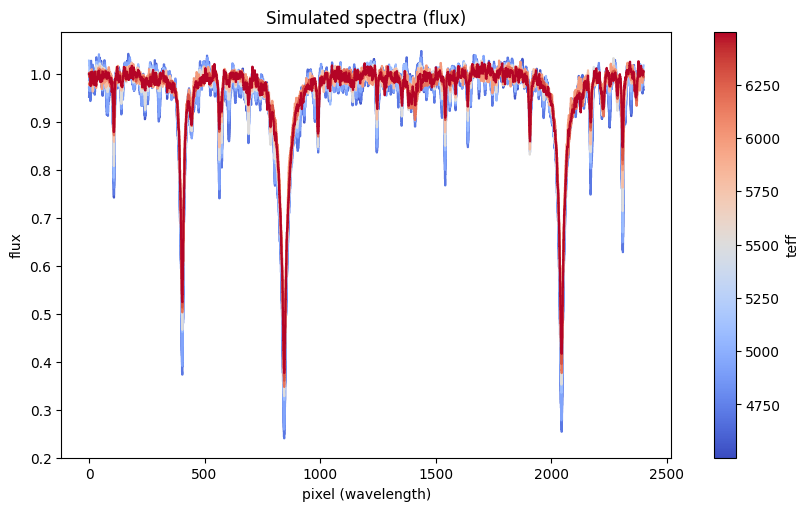

In [293]:
cmap = plt.get_cmap("coolwarm")
norm = mpl.colors.Normalize(
    vmin=stars_dict["label"][:, 0].min(), vmax=stars_dict["label"][:, 0].max()
)
fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")

idx = np.argsort(stars_dict["label"][:, 0])
for i in np.linspace(0, len(idx) - 1, 16).astype(int):
    ax.plot(
        stars_dict["flux"][idx[i]],
        marker="",
        drawstyle="steps-mid",
        color=cmap(norm(stars_dict["label"][idx[i], 0])),
    )
ax.set(xlabel="pixel (wavelength)", ylabel="flux", title="Simulated spectra (flux)")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(sm, ax=ax)
cb.set_label(f"{labels[0]}")

plt.show()

To use this data with the {py:class}`~pollux.models.LuxModel`, we will need to define a {py:class}`~pollux.data.PolluxData` instance. This object acts as a container for the data and uncertainties, and also provides a mechanism to define "pre-processors" for the data. In this case, we will define pre-processors that normalize the labels and spectra to have zero mean and unit variance:

In [294]:
all_data = plx.data.PolluxData(
    flux=plx.data.OutputData(
        stars_dict["flux"],
        err=stars_dict["flux_err"],
        preprocessor=plx.data.ShiftScalePreprocessor.from_data(stars_dict["flux"]),
    ),
    label=plx.data.OutputData(
        stars_dict["label"],
        err=stars_dict["label_err"],
        preprocessor=plx.data.ShiftScalePreprocessor.from_data(stars_dict["label"]),
    ),
)

preprocessed_data = all_data.preprocess()

In [295]:
train_data = preprocessed_data[: n_stars // 2]
test_data = preprocessed_data[n_stars // 2 :]
len(train_data), len(test_data)

(1447, 1447)

# Construct Lux model

In [296]:
model = plx.LuxModel(latent_size=n_latents)

In [297]:
print(all_data.keys())  # noqa: T201
model.register_output("label", LinearTransform(output_size=n_labels))
model.register_output("flux", LinearTransform(output_size=n_flux))

dict_keys(['flux', 'label'])


In [298]:
rngs = jax.random.split(jax.random.PRNGKey(42), 3)

# For this demo, we'll generate outputs for 10 objects
latents = jax.random.normal(rngs[0], shape=(10, model.latent_size))
pars = {
    "label": {"A": jax.random.normal(rngs[1], shape=(n_labels, model.latent_size))},
    "flux": {"A": jax.random.normal(rngs[2], shape=(n_flux, model.latent_size))},
}
outputs = model.predict_outputs(latents, pars)
outputs["label"].shape, outputs["flux"].shape

((10, 4), (10, 2401))

## Optimizing the model with training data (i.e. training the model)

In [299]:
opt_pars, svi_results = model.optimize(
    train_data,
    rng_key=jax.random.PRNGKey(112358),
    optimizer=numpyro.optim.Adam(1e-3),
    num_steps=10_000,
    svi_run_kwargs={"progress_bar": False},
)
svi_results.losses.block_until_ready()

Array([1.13942683e+08, 1.13665998e+08, 1.13391719e+08, ...,
       3.87077007e+06, 3.87076490e+06, 3.87075973e+06], dtype=float64)

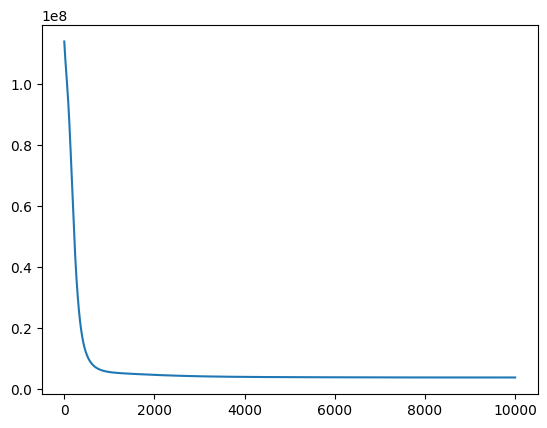

In [300]:
plt.plot(svi_results.losses[-10000:])
plt.show()

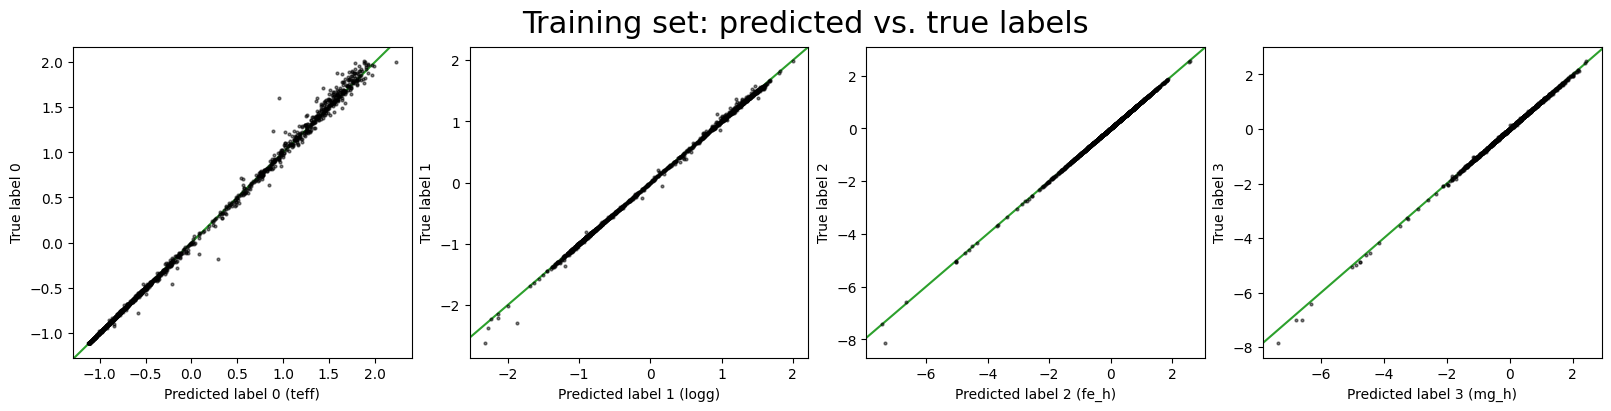

In [301]:
predict_train_values = model.predict_outputs(opt_pars["latents"], opt_pars)

pt_style = {"ls": "none", "ms": 2.0, "alpha": 0.5, "marker": "o", "color": "k"}

fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4), layout="constrained")
for i in range(predict_train_values["label"].shape[1]):
    axes[i].plot(
        predict_train_values["label"][:, i], train_data["label"].data[:, i], **pt_style
    )
    axes[i].set(xlabel=f"Predicted label {i} ({labels[i]})", ylabel=f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle("Training set: predicted vs. true labels", fontsize=22)

plt.show()

## Optimize for latents for test set

In [302]:
fixed_pars = {
    "label": {"data": {"A": opt_pars["label"]["data"]["A"]}},
    "flux": {"data": {"A": opt_pars["flux"]["data"]["A"]}},
}

test_opt_pars, test_svi_results = model.optimize(
    test_data,
    rng_key=jax.random.PRNGKey(12345),
    optimizer=numpyro.optim.Adam(1e-3),
    num_steps=10_000,
    fixed_pars=fixed_pars,
    svi_run_kwargs={"progress_bar": False},
)
test_svi_results.losses.block_until_ready()

Array([1.25420308e+10, 1.24587776e+10, 1.23758111e+10, ...,
       4.39217984e+06, 4.39204742e+06, 4.39191501e+06], dtype=float64)

In [303]:
predict_test_values = model.predict_outputs(test_opt_pars["latents"], fixed_pars)

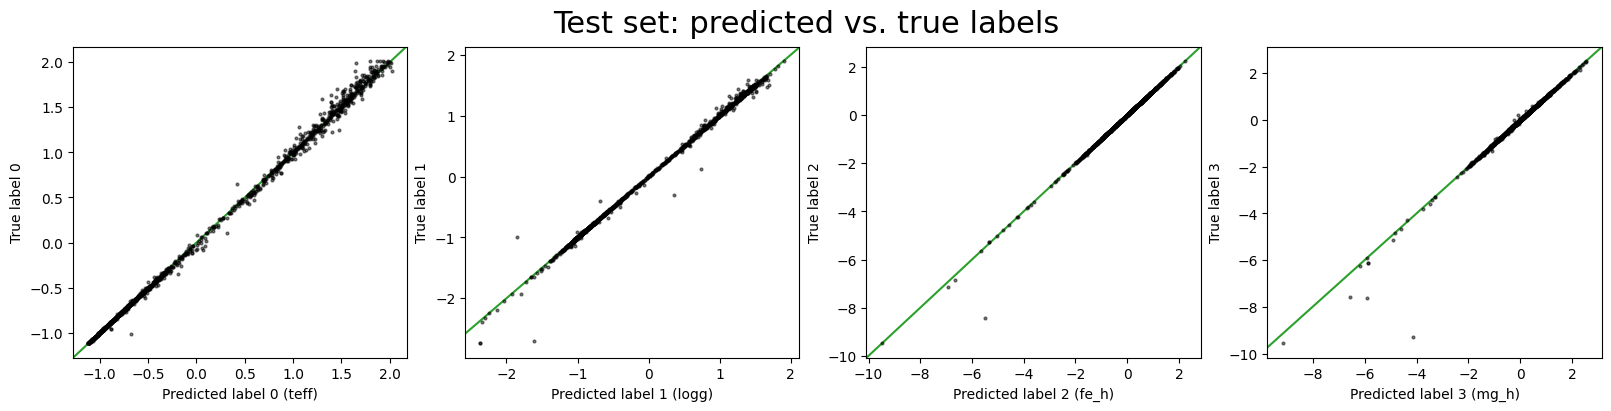

In [304]:
fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4), layout="constrained")
for i in range(predict_test_values["label"].shape[1]):
    axes[i].plot(
        predict_test_values["label"][:, i], test_data["label"].data[:, i], **pt_style
    )
    axes[i].set(xlabel=f"Predicted label {i} ({labels[i]})", ylabel=f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle("Test set: predicted vs. true labels", fontsize=22)

plt.show()

# with partial data (flux only)

In [305]:
flux_only_data = plx.data.PolluxData(flux=test_data["flux"])

In [306]:
test_opt_pars_flux, _ = model.optimize(
    flux_only_data,
    rng_key=jax.random.PRNGKey(12345),
    optimizer=numpyro.optim.Adam(1e-3),
    num_steps=10_000,
    fixed_pars=fixed_pars,
    names=["flux"],
    svi_run_kwargs={"progress_bar": False},
)

In [307]:
predict_test_values_flux = model.predict_outputs(
    test_opt_pars_flux["latents"], fixed_pars
)
predict_test_unprocessed_flux = test_data.unprocess(predict_test_values_flux)

In [317]:
predict_test_unprocessed_flux['label'][:,1]

OutputData(
  data=f64[1,1447],
  err=weak_f64[1447],
  preprocessor=ShiftScalePreprocessor(loc=f32[4], scale=f32[4])
)

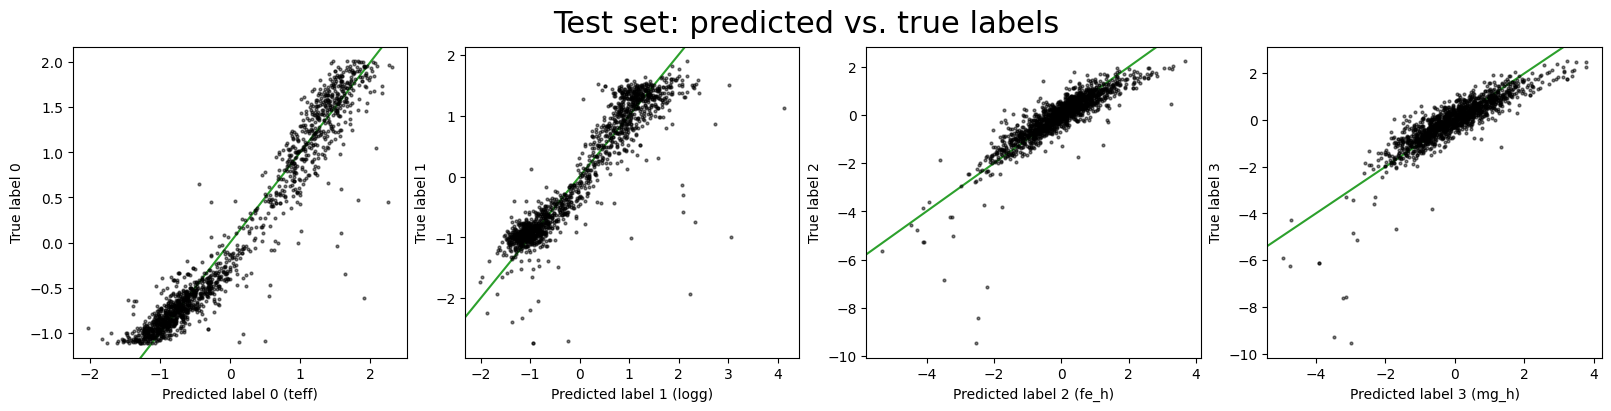

In [308]:
fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4), layout="constrained")
for i in range(predict_test_values_flux["label"].shape[1]):
    axes[i].plot(
        predict_test_values_flux["label"][:, i], test_data["label"].data[:, i], **pt_style
    )
    axes[i].set(xlabel=f"Predicted label {i} ({labels[i]})", ylabel=f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle("Test set: predicted vs. true labels", fontsize=22)

plt.show()

In [309]:
above_solar_fe_mask = df_stars['fe_h'] > 0
above_solar_mg_mask = df_stars['mg_h'] > 0
above_solar_fe = df_stars[above_solar_fe_mask]
above_solar_mg = df_stars[above_solar_mg_mask]

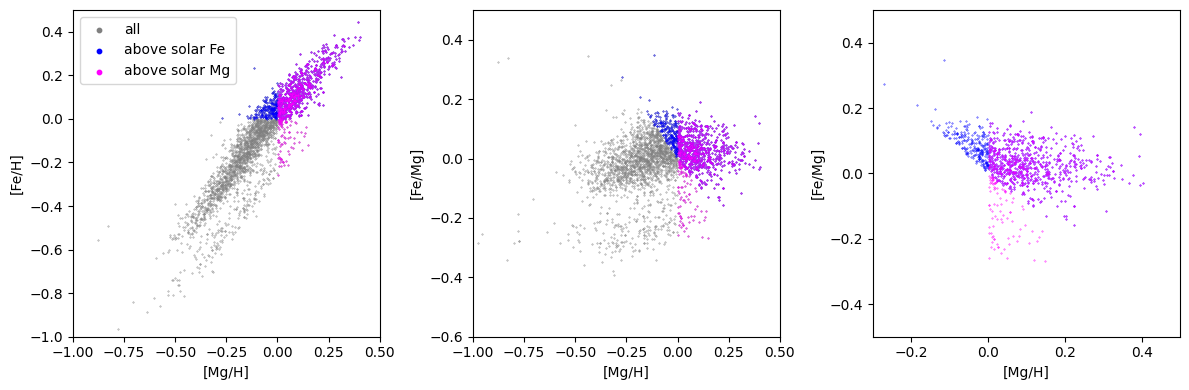

In [310]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(df_stars['mg_h'], df_stars['fe_h'], s = 0.1, label = 'all', color = 'gray')
plt.scatter(above_solar_fe['mg_h'], above_solar_fe['fe_h'], s = 0.1, label = 'above solar Fe', color = 'blue')
plt.scatter(above_solar_mg['mg_h'], above_solar_mg['fe_h'], s = 0.1, label = 'above solar Mg', color = 'magenta')
plt.xlabel('[Mg/H]')
plt.ylabel('[Fe/H]')
plt.xlim(-1,0.5)
plt.ylim(-1,0.5)
plt.legend(markerscale = 10)


plt.subplot(1,3,2)
plt.scatter(df_stars['mg_h'], df_stars['fe_h'] - df_stars['mg_h'], s = 0.1, color = 'gray')
plt.scatter(above_solar_fe['mg_h'], above_solar_fe['fe_h'] - above_solar_fe['mg_h'], s = 0.1, color = 'blue')
plt.scatter(above_solar_mg['mg_h'], above_solar_mg['fe_h'] - above_solar_mg['mg_h'], s = 0.1, color = 'magenta')
plt.xlabel('[Mg/H]')
plt.ylabel('[Fe/Mg]')
plt.xlim(-1,0.5)
plt.ylim(-0.6, 0.5)


plt.subplot(1,3,3)
plt.scatter(above_solar_fe['mg_h'], above_solar_fe['fe_h'] - above_solar_fe['mg_h'], s = 0.1, color = 'blue')
plt.scatter(above_solar_mg['mg_h'], above_solar_mg['fe_h'] - above_solar_mg['mg_h'], s = 0.1, color = 'magenta')
plt.xlabel('[Mg/H]')
plt.ylabel('[Fe/Mg]')
plt.xlim(-0.3,0.5)
plt.ylim(-0.5, 0.5)

plt.tight_layout()

Text(0, 0.5, 'Logg')

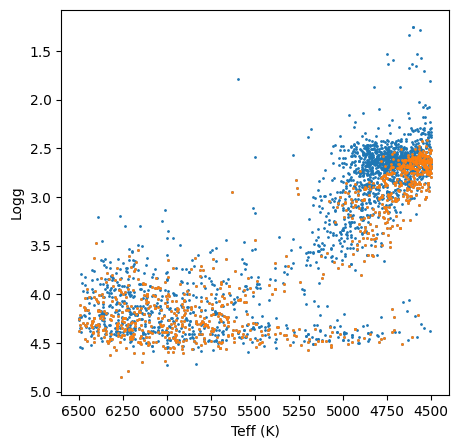

In [312]:
above_solar_fe_mask = df_stars['fe_h'] > 0
above_solar_mg_mask = df_stars['mg_h'] > 0
above_solar_fe = df_stars[above_solar_fe_mask]
above_solar_mg = df_stars[above_solar_mg_mask]

plt.figure(figsize=(5,5))
plt.scatter(df_stars['teff'], df_stars['logg'], s = 1)
plt.scatter(above_solar_fe['teff'], above_solar_fe['logg'], s = 1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Teff (K)")
plt.ylabel("Logg")